<a href="https://colab.research.google.com/github/acevedo-s/Machine-learning-phases-of-matter/blob/master/Honeycomb_Dense.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import csv
import random
import matplotlib.pyplot as plt
from google.colab import drive  
drive.mount('/content/drive')

import keras
keras.__version__
from keras import models
from keras import layers
from keras import regularizers
from keras import optimizers
from keras.utils import to_categorical  
from keras.regularizers import l2

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Using TensorFlow backend.


In [ ]:
def loadD(name,datapath,labelflag,Tc,a,trainflag):
  print(name) #only for reference
  data=[]
  with open(datapath, newline='\n') as csvfile: #read data file
    csv_reader = csv.reader(csvfile, delimiter=' ')
    for line in csv_reader:
      line.remove('') #remove this white space
      if (labelflag==0): #if not labeled, i label it.
          if (float(line[0])<Tc):
            line.insert(0,0)
          else:
            line.insert(0,1)
      data.append(line)

  if (trainflag):
    window=[] # i remove a window from data with T close to Tc
    for x in data[:]:
      if (abs(Tc-float(x[1]))<a): # T=data[k][1]
        window.append(x)
        data.remove(x)
  #now data only has data far from Tc
  r=0.75 ; l=int(r*len(data))
  train_data=data[:l]  #i partition here the hole data set between train data and test data.
  random.shuffle(train_data)
  test_data=data[l:len(data)]
  if (trainflag):
    test_data=test_data+window
  del(data)

  train_labels,train_temperatures,train_data=get_format(train_data) #(validation data will be a fraction of the train data)
  test_labels,test_temperatures,test_data=get_format(test_data)

  print('lenght of train data: ', len(train_data))
  print('lenght of test data: ', len(test_data))

  checkflag=1
  if trainflag:
    if checkflag:
      c=0
      for T in train_temperatures: # to see if some forbidden temperature is still in the training set.
        if(abs(T-Tc)<a):
          c+=1
      print('checkflag:',c)
  return [train_data,train_labels,test_data,test_labels,test_temperatures]
###################-----------------
def get_format(data):
  labels=[]
  temperatures=[]
  for element in data:
    label=element.pop(0) # remove the first element, the label
    labels.append(label) # add to label list
    TT=element.pop(0)  # remove the second element, the temperature
    temperatures.append(TT) # add to temperature list
  #numpy arrays of strings, and string to integers
  data=np.array(data)
  #data=data.reshape(len(data),30,30,1) # uncomment for CNNS
  data = data.astype(np.float)
  data=(data+1.)/2 # normalization
  labels=np.array(labels)
  labels=labels.astype(np.int)
  temperatures=np.array(temperatures)
  temperatures=temperatures.astype(np.float)
  return labels,temperatures,data
#######################---------------------------

def ProbabilityPredictions(model,test_data,test_temperatures):
  test_predictions=model.predict(test_data)
  prob_T=[]
  for j in range(len(test_temperatures)):
    prob_T.append([test_temperatures[j],test_predictions[j]])
  #print(prob_T[0])
  prob_T=sorted(prob_T,key=lambda x: x[0]) # ordered by temperatures
  len(prob_T)

  #prob_TNP=np.array([])
  j=0
  epsilon=0.001
  j_max=len(prob_T)

  while(j+1 < j_max-1): # for the same temperatures i average the results
    count=1
    while(j+1 < j_max and abs(prob_T[j][0]-prob_T[j+1][0])<epsilon):
      count=count+1
      x=prob_T.pop(j+1)
      prob_T[j][1]=prob_T[j][1]+x[1]
      j_max=len(prob_T)
    prob_T[j][1]=prob_T[j][1]/float(count)
    j=j+1
    j_max=len(prob_T)
  
  print('number of temperatures: ',len(prob_T))
  T_list=[];p1_list=[];p2_list=[];check_list=[]
  for j in range(len(prob_T)):
    T_list.append(prob_T[j][0])
    p1_list.append(prob_T[j][1][0])
    p2_list.append(prob_T[j][1][1])
    #check_list.append(prob_T[j][1][1] +prob_T[j][1][0] )
  return [T_list,p1_list,p2_list]

########################----------
########################----------------------------------------

#for fancy plotting
plt.rcParams['xtick.labelsize']=18
plt.rcParams['ytick.labelsize']=18
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'


In [ ]:
def makedicy(name,L,path,label,Tc,loadflag,categoricalflag):
  mydict={'name': name,'L':L,'path':path,'label':label,'Tc':Tc\
          ,'loadflag':loadflag,'categoricalflag':categoricalflag}
  return mydict

Dicyslist=[];
Tclists=[];Llists=[];

#honeycombe lattice
Llists.append([30,20,10])
Tclists.append([1.519,1.519,1.519])
Nhoney=len(Llists[0])

k=0
name='Honeycombe'+str(Llists[0][k])
path='drive/My Drive/Machine Learning magnetism/paper2020/data_honey_AF/900/arrays_'+str(Llists[0][k])+'_-0.00.txt'
x=makedicy(name,Llists[0][k],path,0,Tclists[0][k],1,1)
Dicyslist.append(x)
Nfiles=1

for k in range(1,Nhoney):
  name='Honeycombe'+str(Llists[0][k])
  path='drive/My Drive/Machine Learning magnetism/paper2020/data_honey_AF/arrays_'+str(Llists[0][k])+'_0.0.txt'
  x=makedicy(name,Llists[0][k],path,1,Tclists[0][k],1,1)
  Dicyslist.append(x)
  Nfiles+=1



In [ ]:
#adding data to diccionary  
#'data' format is as follows: 
# train_data,train_labels,test_data,test_labels,test_temperatures
a=0.3 # parameter to exclude transition data from training
trainflag=1
for k in range(Nfiles): # this takes a while
  if(Dicyslist[k]['loadflag']):
    Dicyslist[k]['data']=loadD(Dicyslist[k]['name'],Dicyslist[k]['path'] \
                            ,Dicyslist[k]['label'],Dicyslist[k]['Tc'],a,trainflag)
    Dicyslist[k]['loadflag']=0 # i only read it once. 

Honeycombe30
lenght of train data:  51900
lenght of test data:  28100
checkflag: 0
Honeycombe20
lenght of train data:  51900
lenght of test data:  28100
checkflag: 0
Honeycombe10
lenght of train data:  51900
lenght of test data:  28100
checkflag: 0


###Training

In [ ]:
# Keras formatting
for k in range(Nfiles): 
  if (Dicyslist[k]['categoricalflag']):
    Dicyslist[k]['data'][1] = to_categorical(Dicyslist[k]['data'][1])
    Dicyslist[k]['data'][3] = to_categorical(Dicyslist[k]['data'][3])
    Dicyslist[k]['categoricalflag']=0; # because this must be done only one time.


In [ ]:
def train(Dicyslist,k):
  L=Dicyslist[k]['L']
  damn=optimizers.Adam(lr=0.0005,beta_1=0.9, beta_2=0.999, amsgrad=False)
  model = models.Sequential()
  Ndense=16 # number of neurons in the dense hidden layer
  model.add(layers.Dense(Ndense, activation='relu', activity_regularizer=l2(0.00005)))
  model.add(layers.Dense(2, activation='softmax'))
  epochs_val=10
  Bsize=128 #
  VS=0.1 #validation split

  #optimizer='rmsprop'
  #metrics=[keras_metrics.precision(), keras_metrics.recall()]
  #metrics=['accuracy']
  model.compile(optimizer=damn,
  loss='categorical_crossentropy',
  metrics=['accuracy'])#,keras.metrics.Precision(), keras.metrics.Recall()] )
  history=model.fit(Dicyslist[k]['data'][0], Dicyslist[k]['data'][1], validation_split=VS,
            shuffle=True, epochs=epochs_val, batch_size=Bsize)
  # train_data,train_labels,test_data,test_labels,test_temperatures
  history_dict = history.history
  return model, history_dict

# ###Validation graphs
# print('history_dictionary: ', history_dict.keys())
# loss_values = history_dict['loss']
# val_loss_values = history_dict['val_loss']
# epochs = range(1, epochs_val + 1)
# #“bo” is for “blue dot.”
# plt.plot(epochs, loss_values, 'bo', label='Training loss')
# plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
# plt.title('Training and validation loss')
# #“b” is for “solid blue line.”
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()
# plt.clf()

# #plotting accuracies
# acc_values=history_dict['accuracy']
# val_acc_values=history_dict['val_accuracy']
# plt.plot(epochs, acc_values, 'bo', label='Training acc')
# plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
# plt.title('Training and validation accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

In [ ]:
modellist=[];
historylist=[]
for k in range(Nfiles):
  model,history=train(Dicyslist,k)
  modellist.append(model)
  historylist.append(history)

Train on 46710 samples, validate on 5190 samples
Epoch 1/10
46710/46710 [==============================] - 1s 23us/step - loss: 0.1822 - accuracy: 0.9946 - val_loss: 0.1287 - val_accuracy: 1.0000
Epoch 2/10
46710/46710 [==============================] - 1s 21us/step - loss: 0.1082 - accuracy: 1.0000 - val_loss: 0.0896 - val_accuracy: 1.0000
Epoch 3/10
46710/46710 [==============================] - 1s 20us/step - loss: 0.0794 - accuracy: 1.0000 - val_loss: 0.0695 - val_accuracy: 1.0000
Epoch 4/10
46710/46710 [==============================] - 1s 20us/step - loss: 0.0631 - accuracy: 1.0000 - val_loss: 0.0570 - val_accuracy: 1.0000
Epoch 5/10
46710/46710 [==============================] - 1s 21us/step - loss: 0.0528 - accuracy: 1.0000 - val_loss: 0.0484 - val_accuracy: 1.0000
Epoch 6/10
46710/46710 [==============================] - 1s 20us/step - loss: 0.0453 - accuracy: 1.0000 - val_loss: 0.0425 - val_accuracy: 1.0000
Epoch 7/10
46710/46710 [==============================] - 1s 21us/ste

number of temperatures:  200
number of temperatures:  200
number of temperatures:  200


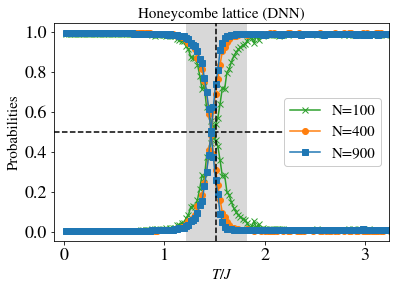

In [ ]:
###predictions:
p1_list=[];
p2_list=[];
k=0
for k in range (Nfiles):
  T_list,x,y=ProbabilityPredictions(modellist[k],Dicyslist[k]['data'][2],Dicyslist[k]['data'][4])
  p1_list.append(x)
  p2_list.append(y)

#plot honey
Tc=Dicyslist[0]['Tc']
markers=['s','o','x']
colors=plt.rcParams['axes.prop_cycle'].by_key()['color']

T_list=[]
T=0.022650
dT=(4.53-T)/200
for i in range (200):
  T_list.append(T)
  T+=dT

fig = plt.figure()
ax = fig.add_subplot(111)  
from google.colab import files
file_name="dense_honeycombe_seccion1.pdf"

klist=[2,1,0]
for k in klist:
  size='N='+str(Dicyslist[k]['L']**2)
  plt.plot(T_list, p1_list[k], label=size, c=colors[k],marker=markers[k])#,mfc='none') #
  plt.plot(T_list, p2_list[k], c=colors[k],marker=markers[k])#,mfc='none')#, label='')


plt.title('Honeycombe lattice (DNN)',size = 15)
plt.xlabel(r'$T/J$',size = 15)
plt.ylabel('Probabilities',size = 15)
plt.legend(loc='center right',prop={'size': 15},framealpha=1)
plt.axvline(x=Tc,color='black',linestyle='--')
xmaxx=2*Tc+.2
plt.hlines(y=0.5,xmin=-0.1,xmax=0.7*xmaxx,color='black',linestyle='--')
g1=Tc-a ; g2=Tc+a
plt.axvspan(g1, g2, color='gray', alpha=0.3, lw=0) # shaded gray
ax.set_xlim(-0.1,xmaxx)
plt.savefig(file_name)
plt.show()


In [ ]:
files.download(file_name) 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>